# Experiment Data 2

In this notebook I mainly want to investigate if we can say something significant about the inferred data. 

We will do this by considering many different situations/species subsamples and will be considering many different subsets where we will then statistically test if they originate from the same true value.

In [1]:
### Auto reloading moduls
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from helpFunctions import *
from generateGLV import *
from fitGLV import *
from mpl_toolkits.mplot3d import Axes3D
import time
from matplotlib import gridspec

------
next import the clean data:

In [3]:
x = pd.read_csv('InputData/NewDavid_Data/25_timeseries.txt', na_values='NAN', delimiter='\t', header=None)
TSDavidA = x.T.values

In [15]:
TSDavidA.shape

(365, 100)

# Figure thesis

(0.021831793286914657, 5000)

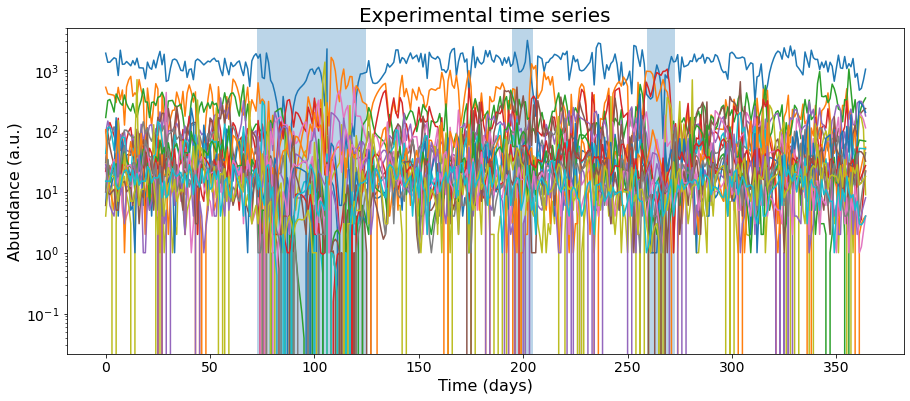

In [4]:
fig = plt.figure(figsize=(15,6))
plt.plot(TSDavidA[:,0::5],) # plot 1 species in 5p
plt.yscale("log")

plt.title("Experimental time series",fontsize=20)
plt.ylabel("Abundance (a.u.)",fontsize=16)
plt.xlabel("Time (days)",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)


PertuAll = np.full(len(TSDavidA)-1,False)
PertuAll[73:125]=True
PertuAll[260:273]=True
PertuAll[195:205]=True
plt.bar(np.arange(len(PertuAll)),PertuAll*5000,width=1,alpha=0.3)
plt.ylim(top=5000)
#plt.savefig("ThesisFigures/ExperimentFig/Timeseries.png")

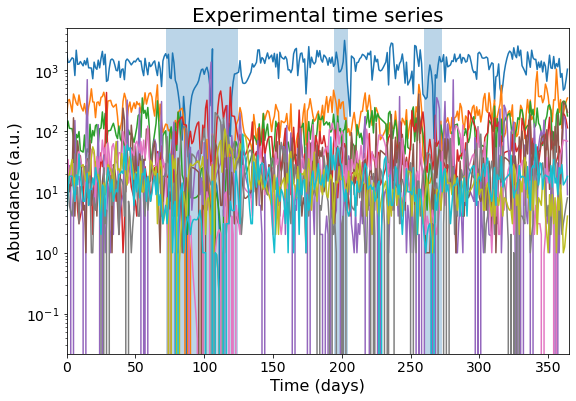

In [60]:
fig = plt.figure(figsize=(9,6))
plt.plot(TSDavidA[:,0::10],) # plot 1 species in 5p
plt.yscale("log")

plt.title("Experimental time series",fontsize=20)
plt.ylabel("Abundance (a.u.)",fontsize=16)
plt.xlabel("Time (days)",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(0,365)

PertuAll = np.full(len(TSDavidA)-1,False)
PertuAll[73:125]=True
PertuAll[260:273]=True
PertuAll[195:205]=True
plt.bar(np.arange(len(PertuAll)),PertuAll*5000,width=1,alpha=0.3)
plt.ylim(top=5000)
#plt.savefig("ThesisFigures/ExperimentFig/TimeseriesSmall.png")

Now the rank abundance distribution in log-scale:

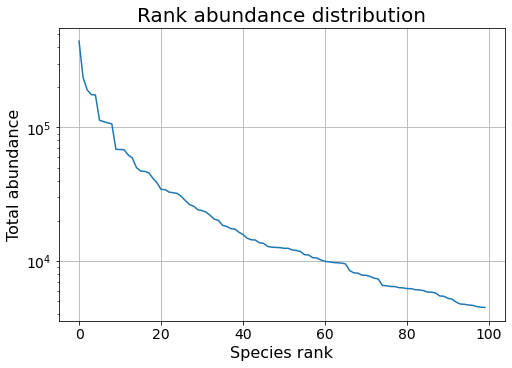

In [5]:
fig = plt.figure(figsize=(7,5),constrained_layout=True)
TSTotal = np.sum(TSDavidA,axis=0)
RelatifTotal = TSTotal/np.sum(TSTotal)

#plt.plot(RelatifTotal) # There is this one really low one.
plt.plot(TSTotal)

plt.yscale("Log")

plt.title("Rank abundance distribution",fontsize=20)
plt.xlabel("Species rank",fontsize=16)
plt.ylabel("Total abundance",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.savefig("ThesisFigures/ExperimentFig/RankAbundance.png")

## Create different types of datasets:

### Set 0 to a low amount:

To deal with 0's in the data one has a few options. Previously, I removed those species, however one now has the problem that maybe one removes a heavy abundancy species on the basis of just a single point. 

In this new approach I will rather just set the species to alow amoutn. Since the lowest measurment possible by the data = 1. I will set 0 species equal to 0.1, Still an order of magnitude lower then the lowest values -> Hence if the real abundancy where this, it would not have been measured. 

On the other hand if the species was really zero, then maybe 0.1 is to high. It is always a balance trade of between species that were really zero and species that where just so low it was not measured. 

In [4]:
TSSafe = np.copy(TSDavidA)
TSSafe[TSSafe==0] = 0.01

### Taking different timesteps

The first difference between the datasets that we want to vieuw are the restriction of only using certain timesteps. 

The main consideration is ofcourse the removal of pertubation regions. However, from the previous notebook we also saw that after the abroad it seemed that for some species moved to a different steady state. And so maybe the steady state after the abroad is not the same. That's why will consider two cases where we just completly remove the first part and hope to only view 1 steadystate.

- No removal at all
- Removal abroad
- Removal abroad and two smaller pertubation regions.
- Removal abroad and before
- Removal abroad and before and the two small pertubations.



In [5]:
Zones = ["All","Abroad","Pertu","Section","SectionP"]

All: meaning nothing is removed, in the other cases those are removed

Section = abroad region and that before.
SectionP = Section + P = pertubations.

In [6]:
dBool = {} # Dictionary of boolians.

for zone in Zones:
    dBool[zone] = np.full( len(TSSafe)-1 , False)
    
# Flag the appropiate regions with true boolians
dBool["Abroad"][73:125] = True
dBool["Pertu"][73:125] = True
dBool["Pertu"][260:273] = True
dBool["Pertu"][195:205] = True
dBool["Section"][0:125] = True
dBool["SectionP"][0:125] = True
dBool["SectionP"][260:273] = True
dBool["SectionP"][195:205] = True

# Create a TS version of the boolians
for key, boolVect in dBool.copy().items():
    if key[:7]=="Section":
        updatedBool = np.append(boolVect,False)
    else:
        updatedBool = np.append(False,boolVect)
    dBool["TS_"+key] = updatedBool

Pertubations are highlighted with a boolian vector. Since a pertubation occurs always BETWEEN points we thus have a boolian vector of length -1. And thus tells us if a pertubation has happend between two points. 

However, often in our analyis down here we want to only make some conditions based on TS in the valid areas. Thus we want a boolian vector that we can apply on the TS directly. There for we need to extend its length. I have now chosen to append a "False" on the front. Since meaning we will always consider the first point of our times point as valid. Then after that we can remove points if they happend after a pertubation. 

And exception to this is the removal of the first part, there we do not want a "False" for the first timestep. Hence, we add it at the end.

### Consider the first N by abundancy:

The next subset we want to consider are that of different species. Since we cannot consider all species off them. So to ensure that we are considering the best species that could have the most impact we are considering species with the highest abundancy with the reasoning that low species abundancy are just not abundand enough that they can have an impact on the higher species amounts. 

When taking the first $N$ it important to consider the first $N$ in the region outside that are flagged as invalid. -> This may alter the order a bit around.

Define a vector that holds the species ordered by abudancy in the appriate region. And also store this in a dictionary.

In [8]:
dOrder = {}
for zone in Zones:
    dOrder[zone] = np.argsort( np.sum(TSSafe[~dBool["TS_"+ zone]], axis=0))[::-1]

We will now start creating a dictionary that contains all the databases. For this I adapt a specific naming convention. Where for which I will be able to store all future database:

Name example: `f10_All_MaxStd`

Four different types of informations are given here:

- 10. The 10 or $N$ in general says how many species this dataset maximumly contains. For instance it could be that it says 50 but duo some other restrictions it the data set contains only 43 species. It just means 50 will be the maximum number. By convention we also say that the total data set is higlighted with 100.
- "f": the letter in front tells us a bit more about these $N$ species:
    - "f": the first, for example "f10" = first 10
    - Future expensions are possible such as "c" = custom, or "r" random
- "_All": declares which timezones it should exclude with the exception of ALL -> Here it means that it contains all. But if it says "_Abroad" it means that all Abroad region is not considered in the determination with the other considerations
- "_MaxStd": In general here additional constrains or unique twist can be given. If it left empty then it means that, no additional constraints are given and just the normal TSSave data set was used. We could also here specify for instance "_NoSafe" meaning this is a data set where the base did not set the zero elements to a small number. 

With these convention in place I hope that I will be able to accomidate for every type of data set I can come up with.

Now lets create the datasets that for now contain all the data: given by the names: `f100_zone`

In [9]:
dDataset = {}
for zone in Zones:
    copy_base_dataset = np.copy(TSSafe)
    dDataset["f100_"+zone] = copy_base_dataset[:,dOrder[zone]]

Normalise the data now. Where this normalisation happens per consideration of each reason that is is considered in the dataset:

In [10]:
dSS = {} # Dictionary steadystates SS
for zone in Zones:
    dSS[zone] = np.median(dDataset["f100_"+zone][~dBool["TS_"+zone]], axis=0) 

# Normalise the datasets
for zone in Zones:
    dDataset["f100_"+zone] /= dSS[zone]

Construct a few first $N$ datasets for each pertubations category:

In [11]:
for N in [10,20,50]:
    for zone in Zones:
        dDataset["f"+str(N)+"_"+zone] = dDataset["f100_"+zone][:,:N]

# Thesis figure plotting normalised

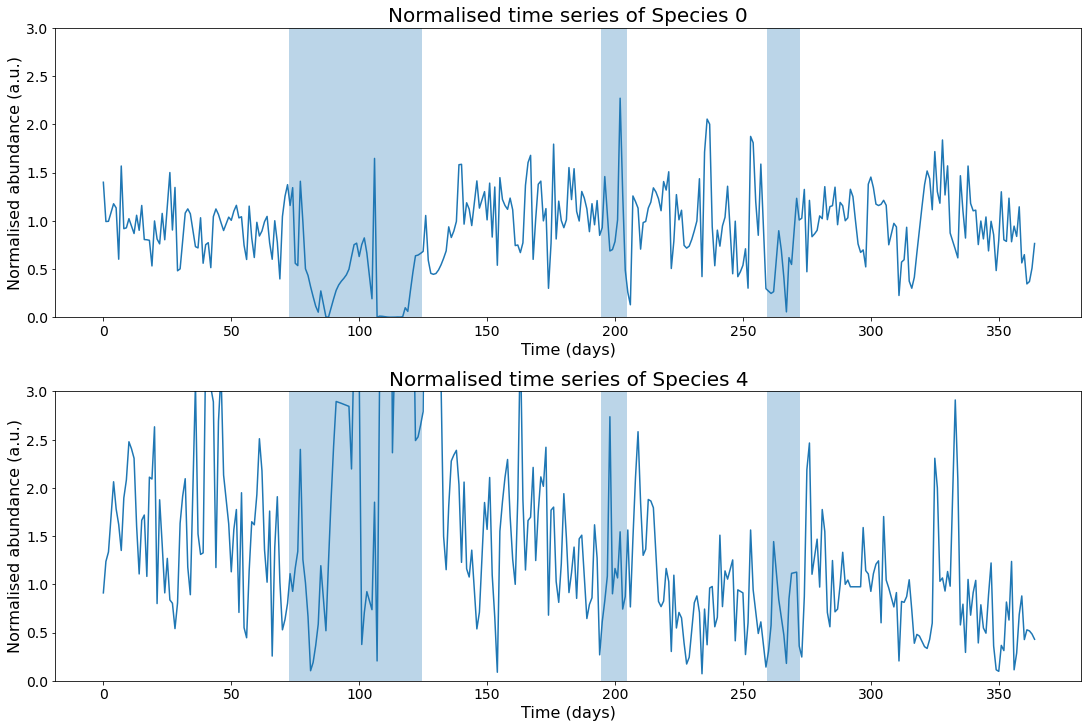

In [12]:

fig, axs = plt.subplots(nrows = 2, ncols= 1,figsize=(15,10),constrained_layout = True )

species = (0,4)
Maxlim = (3,3)

PertuAll = np.full(len(TSDavidA)-1,False)
PertuAll[73:125]=True
PertuAll[260:273]=True
PertuAll[195:205]=True

for i, ax in enumerate(axs):
    ax.set_title(f"Normalised time series of Species {species[i]}",fontsize=20)
    ax.set_ylabel("Normalised abundance (a.u.)",fontsize=16)
    ax.set_xlabel("Time (days)",fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.plot(dDataset['f10_SectionP'][:,species[i]])
    ax.bar(np.arange(len(PertuAll)),PertuAll*3,width=1,alpha=0.3)
    
    ax.set_ylim(0,Maxlim[i])

plt.savefig("ThesisFigures/ExperimentFig/NormalisedTimeSeries.png")

### Consider the first N by abundancy under std threshold

Next, I want to create a data set that also takes the first $N$ by abundancy, however now I impose the additional constraint that I do not want any species which std of its abundancy goes above a certain threshold. In the last notebook "ExperimentData" it was seen that high std species had a negative impact on the inference. 

By creating these datasets we want to test if removing these high std thresholds had an impact on the inferred value of the those that were not removed?

It does not mean that this is the right approach, it just means that we want to evaluate this dataset and compare.

-----

To do this we first need to again make total fit on the normalised data for the different pertubation categories:

In [13]:
dFit = {}
dStdEst = {}
fN = "f50_"
for zone in Zones:
    dFit[fN+zone] = fitGLV({"TS":dDataset[fN+zone],"pertu":dBool[zone]}, typeInput="Experiment")
    dFit[fN+zone].computeNullHypo()
    dStdEst[zone] = np.sqrt( dFit[fN+zone].varEst)

It seems that the dictionary approach reaches different results :/ should not be the case:

On the one hand however we do need to be carefull! Since for this we needed to fit with 100 data points -> Which can cause overfitting. Still let's just role with it.

Set a certain threshold of STD for each pertubation region:

In [14]:
dHighStd = {}
for zone, threshold in zip(Zones, [1, 0.8, 0.8, 0.7, 0.7]):
    dHighStd[zone] =  np.where(dStdEst[zone][0]>threshold)[0]

I have chosen to let the threshold be soupler with the condition that flag less pertubations, since with more pertubations present, it will automatically be more variant.

Now create the dataset a new but now with these bad species removed first. I do not have to change the order, since they were already orderd, I now just remove certain species. Leaving the order still intact.

In [15]:
for zone in Zones:
    safe_copy_fullDataset = np.copy(dDataset["f100_"+zone])
    dDataset["f100_"+zone+"_MaxStd"] = np.delete(safe_copy_fullDataset, dHighStd[zone], axis=1)

Now take again the first $N$

Many datasets do not make it over the 50...

In [16]:
for N in [10,20,50]:
    for zone in Zones:
        dDataset["f"+str(N)+"_"+zone+"_MaxStd"] =  dDataset["f100_"+zone+"_MaxStd"][:,:N]

So we now have created the datasets that we want to evaluate and see if there prediction for a certain parameters changes severly:

We have the following categries:

- 5 Different timeregions consider
- 3 Different first $N$
- with and without STD constrain

Giving us a total of 30 different sets to work with. So what I first to make a comparison matrix is a bit much right now. So select only a handfull of data sets that you want to compare against each other. And create this will mutliple smaller matrixes. 

Between these different data sets we now want to compare if the fitting a given parameters stays roughly the same. Later on we will even create subsets of independed datasets to statistical significant tests. But for now we are simply going to compare the ratio.

Ofcourse it is important that we compare the fitted interaction between the same species!! Which is not that easy since we shuffeld for each dataset two times:

- First: We have reorderd the species according to the abundancy in there respectif valid region.
- Second: We have deleted species, where the index of the species that are deleted are the output of the first reordening ! This deletion only happend when talking about the MaxSTD.

So what we first need to figure out is a way to find the same species. And have a way to check if it maybe does not exist in a certain dataset.

A first step to do this is just with the data sets where no species have been deleted. And then figure out how to do it with the species deleted. 

### Comparing species between datasets:

What we will be doing is have dictionary with the key being the reference number of that species and the value being the column that species with that reference key number corresponds with in the dataset. 

First lets just do it for the non maxSTD datasets:

In [17]:
def toDict(orderDataset):
    datasetDict = {}
    for i, j in enumerate(orderDataset):
        datasetDict[i] = np.where(orderDataset==i)[0][0]
    return datasetDict

In [18]:
dDictSpecies = {}
for zone in Zones:
    dDictSpecies["f100_"+zone] = toDict(dOrder[zone])

Now consider the removale of species orderd by the value. 

In [19]:
def removeSpeciesFromDict(dictDataset, columnsToRemove):
    newDict = {}
    sortedColumns = np.sort(columnsToRemove)
    for refSpecies, oldColumn in dictDataset.items():
        if oldColumn not in sortedColumns:
            newDict[refSpecies] = oldColumn - np.sum(sortedColumns<oldColumn)
    return newDict

comments on the function removeSpeciesFromDict:

DictDataset = current key-column setup of a dataset. There are gaps allowed in the present keys but no gaps are allowed in the columns. Every number needs to be present from 0 to len(dict)-1.
    
columnsToRemove = list of columns that are being removed from dataset.
    
newDict =  The correct dictionary of the new dataset. Every number between 0 to len(dict) len(columnsToRemove)-1 needs to be present in the values of the new dictionary

In [20]:
for zone in Zones:
    dDictSpecies["f100_"+zone+"_MaxStd"] =  removeSpeciesFromDict(dDictSpecies["f100_"+zone], dHighStd[zone])

To test, look at some dictioniaries that share a reference species and then look if they plot the same and compare with the reference TSSafe.

-> After some debugging it works fine!

In [21]:
def dictFirstN(dictionary, N):
    dictFirstN = {}
    for refSpecies, column in dictionary.items():
        if column<N:
            dictFirstN[refSpecies] = column
    return dictFirstN

Create all the new datasets and store them in the dictionary

In [22]:
for N in [10,20,50]:
    for zone in Zones:
        for cond in ["","_MaxStd"]:
            dDictSpecies["f"+str(N)+"_"+zone+cond] = dictFirstN(dDictSpecies["f100_"+zone+cond],N)

Let's find the species that are contained in every dataset!

In [23]:
listSpeciesLeft = list(range(100))
for dic in dDictSpecies.values():
    SpeciesInDataset = np.fromiter(dic.keys(),dtype= int)
    for speciesLeft in listSpeciesLeft:
        # If the specie is not contained in the dataset remove it
        if speciesLeft not in SpeciesInDataset:
            listSpeciesLeft.remove(speciesLeft)
listSpeciesLeft

[3, 4, 6, 7, 8]

-> The species 3,4,6,7 and 8 are contained by all the datasets. 

Some other species are for sure also present in many datasets (like 0) but these are present in all. and so we can for sure evaluate the interaction between these for all the data sets!

After some playing around:

1


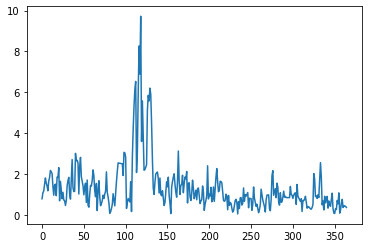

In [110]:
N = "20"
Zone = "All"
cond = "_MaxStd"
RefSpecies = 3

DataSetName = "f"+N+"_"+Zone+cond
columnDataset = dDictSpecies[DataSetName][RefSpecies]

print(columnDataset)
plt.plot(dDataset[DataSetName][:,columnDataset])

--------

# Compare fit results between the different dataSets:

First, complete the fit dictionary:

In [24]:
for N in [10,20,50]:
    for zone in Zones:
        for cond in ["","_MaxStd"]:
            datasetName = "f"+str(N)+"_"+zone+cond 
            dFit[datasetName] = fitGLV({"TS":dDataset[datasetName],"pertu":dBool[zone]}, typeInput= "Experiment")
            dFit[datasetName].computeNullHypo()

In [25]:
def ratioMatrix(species1, species2, datasets):
    """Evaluate interaction term between species1 en species2. 
    Where we talk about growth of species1 that is being influced by species2
    To evaluate growth rate set species2 = -1 
    """
    fittedParameter = []
    for datasetName in datasets:
        try:
            col = dDictSpecies[datasetName][species1] # Columns of beta are associated with the growth of species1
            if species2<0: # If species2 is negatif then we want to evaluate the growthrate of species1
                row = 0
            else: 
                row = dDictSpecies[datasetName][species2]+1 # +1 because the first row is the growthrate of species 1
        except: # Species 1 or 2 is not present in the dataset.
            fittedParameter.append(np.nan)
            continue
        fittedParameter.append(dFit[datasetName].BEst[0,row,col])
        
    fittedParameter = np.array(fittedParameter).reshape(-1,len(fittedParameter))
    return (fittedParameter[0], fittedParameter.T/fittedParameter)

Create a few list of datasets that we want to compare in the matrix 

In [24]:
sectionPNoMaxStd = ["f10_SectionP","f20_SectionP"," "]
sectionPMaxStd = ["f10_SectionP_MaxStd","f20_SectionP_MaxStd","f50_SectionP_MaxStd"]

For the test let's first just test the selfinteraction of the first species.

In [58]:
fitResult, matrix = ratioMatrix(species1=0, species2=1, datasets= sectionPNoMaxStd)
print(fitResult)
print(matrix)

[ 0.03748153 -0.07681765 -0.05116912]
[[ 1.         -0.48792857 -0.73250286]
 [-2.04948033  1.          1.50125021]
 [-1.36518238  0.66611148  1.        ]]


Ok so the code works! great now we just need to make a function that nicely plots this matrix. And start to explore!

In [64]:
# Code for function to plot:

In [65]:
# Explore results and interpret.

---------

# Do they fit the same value?

I now want to statistically asses if the fit that is done fits the same value!

For this we are going to divide the timeseries into two sperate sets and fit the parameters on each sets separatly. And then statistically asses if the fits are possible to originate from the same true value. 

One mainly wants to compare this with the same datasets, but can also be expaned to evaluate between datasets. Here one just needs to make sure that the there were datasets overlap when they use the samepoints -> one needs to correctly divide it between the two. If the other datasets exludes some region but former not, then the former is allowed to use those points since no overlap is possible.

So to create two data sets. One needs to create two modified "pertubation boolian vectors" were you need to add equivalently to the pertubation boolian vector.

In [30]:
def createIndependentSets(zoneDataset1, zoneDataset2):
    boolVect1 = np.copy(dBool[zoneDataset1]) # copy to not alter the original
    lenVec1 = np.sum(boolVect1==False)
    boolVect2 = np.copy(dBool[zoneDataset2])
    lenVec2 = np.sum(boolVect2==False)
    
    shared = np.logical_and(~boolVect1,~boolVect2)# ~ because "False" are the valid regions
    lenShared = np.sum(shared)
    
    setA = np.full(lenShared, False, dtype=bool)
    setA[:lenShared//2] = True # Set half equal to True
    np.random.shuffle(setA) # Random shuffle to divide the data.
    setB = ~setA
    
    # When lenShared is uneven, setA will have one point less.
    # Give setA to the data set who already has more points. 
    boolVect1[shared] = setA if lenVec1>lenVec2 else setB
    boolVect2[shared] = setB if lenVec1>lenVec2 else setA
    return boolVect1, boolVect2

In [29]:
def testSameFit(species1, species2, datasetA, datasetB, zoneA, zoneB, seeds=[0]):
    # Have list for the different results:
    pValues = []
    pSigmas = []
    # Check if the reference species even exist in the datasets before we move on.
    try:
        
        col_DA = dDictSpecies[datasetA][species1]
        col_DB = dDictSpecies[datasetB][species1]
        if species2<0: # Negative species2 means evaluate the growthrate of species1.
            row_DA = 0
            row_DB = 0
        else:
            row_DA = dDictSpecies[datasetA][species2] + 1
            row_DB = dDictSpecies[datasetB][species2] + 1
    except:
        print(species1,species2,datasetA,datasetB,seeds)
        print("Error: species1 or 2 is not know for either datasetA or B")
        return
    
    for seed in seeds:
        np.random.seed(seed)
        SampleA, SampleB = createIndependentSets(zoneA, zoneB)
        fitA = fitGLV({"TS":dDataset[datasetA],"pertu":SampleA}, typeInput="Experiment")
        fitB = fitGLV({"TS":dDataset[datasetB],"pertu":SampleB}, typeInput="Experiment")
        # Make the LeastSquare fit
        fitA.computeVarBEst()
        fitB.computeVarBEst()
    
        # Compute the test statistic for the nullhypothesis that the parameters that were fitted
        # Originated from a possible common true parameter.
    
        B_ijA = fitA.BEst[0,row_DA,col_DA] 
        XA = fitA.X[0]
        invXTXA = np.linalg.inv(XA.T@XA)[row_DA,row_DA]
        nA, pA = XA.shape
        S2_iA = fitA.varEst[0,col_DA]
    
        B_ijB = fitB.BEst[0,row_DB,col_DB] 
        XB = fitB.X[0]
        invXTXB = np.linalg.inv(XB.T@XB)[row_DB,row_DB]
        nB, pB = XB.shape
        S2_iB = fitB.varEst[0,col_DB]
    
        # Compute the test statistic
        Part1 = (B_ijA - B_ijB)/np.sqrt( invXTXA + invXTXB )
        Part2 = np.sqrt( (nA+nB-pA-pB) / (S2_iA*(nA-pA) + S2_iB*(nB-pB)) )
        T = Part1*Part2
    
        pValue = 2*(stats.t.cdf(-abs(T),df = nA+nB-pA-pB))
        pSigma = np.abs(stats.norm.ppf(pValue/2))
        pValues.append(pValue)
        pSigmas.append(pSigma)
    return pValues, pSigmas

Have some random seeds:

In [28]:
seeds = np.random.randint(1e4, size = 100)

In [29]:
f10_SP = "f10_SectionP"
f50_SP = "f50_SectionP"
sectionP = "SectionP"
secAbroad = "Abroad"
pValue, pSigma = testSameFit(3, 0, f10_SP, f10_SP, sectionP, sectionP, seeds = seeds)

(array([10., 20., 14., 16., 12.,  8.,  2.,  7.,  7.,  4.]),
 array([0.00767177, 0.28998127, 0.57229078, 0.85460028, 1.13690978,
        1.41921928, 1.70152878, 1.98383828, 2.26614778, 2.54845728,
        2.83076678]),
 <a list of 10 Patch objects>)

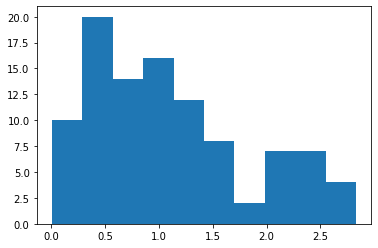

In [30]:
plt.hist(pSigma)

In [31]:
# To summarise the results now: take the median of the results:
np.median(pSigma)

0.93038616937887

The expected median with if the null Hypo is correct would be ofcourse be the median corresponding with the pValue of 50% -> pSigma = 0.67 

**Important** we do not take to many pSigma's because the indeed these pValue should follow a t-distribution of the appriate order. If the data is every time random. Which is not the case! So the resulting pSigma's are not independent since they partually use the same data! The resulting histogram should just give a feeling. Such that we are not blind to 1 seeds result.

But we should be carefull with interpreting the distribution!.

----

Very nice results uptill now. We cannot statistically asses if the fit orginated from a different common variable. Most often this because probably the fits that it gets for the interaction terms are zero. 

While for the significant B_00 interaction it does also statistically fit correctly!

We should be carefull however, because we do not have that much data to work with. In the sectionP nA or nB Is only 108 points big! And so a fitting with 100 or even 50 is not a good idea.

-------
## Explore results:

Create a big interaction matrix where we plot for for each point the median resulted pSigma.

In [25]:
fixedSeed = np.random.randint(1e4, size = 1)
fixedSeed = [7314] # Is a good one.

array([7314])

In [28]:
def sameFitTest_Matrix(dataset1, dataset2, zone1, zone2, seeds, refSpecies = np.arange(100)):
    speciesInD1 = np.fromiter(dDictSpecies[dataset1].keys(), dtype= int)
    speciesInD2 = np.fromiter(dDictSpecies[dataset2].keys(), dtype= int)
    #print(f"Dataset2={dataset2}")
    #print(f"speciesInD2={speciesInD2}")
    interSectD1 = np.intersect1d(refSpecies, speciesInD1, assume_unique=True)
    #print(f"interSectD1={interSectD1}")
    inCommon = np.intersect1d(interSectD1, speciesInD2, assume_unique=True)
    #print(f"inCommon")
    
    lenM = len(refSpecies)
    interMatrix =  np.full((lenM+1,lenM), np.nan)
    
    species1 = inCommon
    species2 = np.append(-1,inCommon) # Add a -1 because we also want to evaluate the growht rate
    for sp1 in species1:
        for sp2 in species2:
            _, pSigmas = testSameFit(sp1, sp2, dataset1, dataset2, zone1, zone2, seeds = seeds)
            interMatrix[sp2+1, sp1] = np.median(pSigmas)
    return interMatrix

In [119]:
dDictSpecies["f10_Section_MaxStd"]

{0: 0, 3: 2, 4: 1, 6: 3, 7: 5, 8: 4, 9: 6, 10: 7, 16: 8, 18: 9}

In [31]:
D1 = "f10_SectionP"
D2 = "f10_SectionP"
ZoneSP = "SectionP"
ZoneAb = "Abroad"

Matrix = sameFitTest_Matrix(D1, D2, ZoneSP, ZoneSP, fixedSeed, np.arange(10))

In [32]:
def plotM_ThesisFigure(Matrix,title,mode="Diff", figsize=(5,5)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    setColorBar= True
    ax = fig.add_subplot(111)
    if mode=="Diff":
        cax = ax.matshow(Matrix, cmap= "jet")
        
    plt.title(title,fontsize=18,pad=28)
    ax.set_xlabel('Column',fontsize=17)    
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Row',fontsize=17)
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    if setColorBar:
        cbar = fig.colorbar(cax,shrink=0.8,pad=-0.02 )
        cbar.set_label(r"p-value of $H_{0,A=B}$ ($\sigma$)",fontsize=17)
        cbar.ax.tick_params(axis='both', which='major', labelsize=13)
    plt.savefig('ThesisFigures/ExperimentFig/TwoSampledResult.png')
    plt.show()

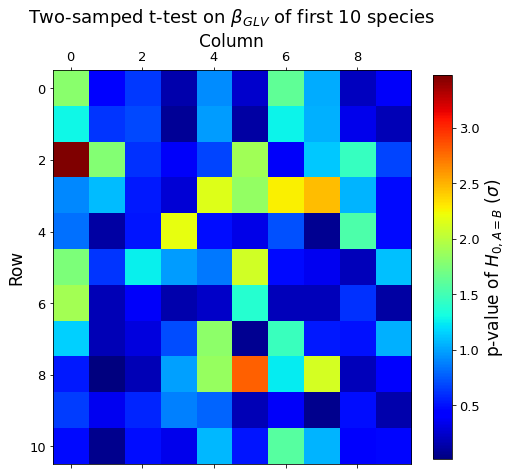

In [33]:
plotM_ThesisFigure(Matrix,r"Two-samped t-test on $\beta_{GLV}$ of first 10 species",figsize=(7,7))

### Result with 10 seeds:

We should not be scared of the 1.4 value -> It is high for the expected median value of 0.67 if indeed every input would also be independed. But this is not the case! -> The input data is not indepened. So we should be carefull...

And maybe really interpret the 1.4 result as this is the result that we would have gotten from an average sameFitTest. And 1.4 is still in the acceptence range -> Hence, for no inferred parameter can we say that the statical test was different.

### When to reject? 

I would say the thereshold here is at 2 sigma. Then it starts to become significant! And reject the null hypo. (Because if your median of 10 seeds is already above 2 sigma) This is highly significant. 

Actually maybe we should set the seed just to 1. Because then it is more direct and not obsucred. Here one needs to however incoporate look else where effects!

When only 1 seed. When threshold? 

- 2 Sigma = 4.5% chance by random (1/22)
- 3 Sigma = 0.27% chance by random (1/370)
- 4 Sigma = 0.0063% chance by Random (1/15873)

-> Count the number of above 2 Sigma in the parameters: $$E(N_{par}>2\sigma) \approx N_{par}*1/22$$

If it is far above that then this is not correct -> Actually one can also do this rigoursly. By knowing that we basically have $N_{par}$ bernoulli experiments resulting in an Binomial distribution for the number above 2 sigma. -> This way one can compute again a p-value to tell if the observed number above 2 Sigma's is significant or not.

-> This way we can statistically say if the globally the parameters that were fitted with the GLV by a the given 

Actually, we can like evaluate this like for every sigma threshold. -> We can thus make a plot with on the x-axis the sigma theshold. -> And sweep from say like sigma 0.5 -> 3.5. And on the y-axis the p-value (or sigma pValue). Now with an eye blink on the plot we can evaluate if the fitted matrix has outliers. 

--------

For example in the example above:

-> See the number of 2 sigma's is higher but not by much (depends on seed), That is why we are going to need to statsically asses this.

In [35]:
def plotBernouliPValue(pSigmaMatrix, plotSigma = True):
    sigma = np.linspace(0.5, 3.5, num=50)
    P = 2*stats.norm.cdf(-sigma) # P-value of one bernoulli experiment
    N = np.sum(~np.isnan(pSigmaMatrix)) # Number of bernoulli experiments
    whereInvalidExp = np.isnan(pSigmaMatrix)
    experiments = pSigmaMatrix[~whereInvalidExp]
    
    numberAboveSigma = np.full(len(sigma),np.nan)
    for i, s in enumerate(sigma):
        numberAboveSigma[i] = np.sum(experiments >= s)
    
    PValue = stats.binom.pmf(numberAboveSigma, N, P)
    PSigma = np.abs(stats.norm.ppf(PValue/2))
    
    
    fig = plt.figure(figsize=(7,5))
    plt.plot(sigma, numberAboveSigma/N, label = r"relatif: N_par > $\sigma$")
    if plotSigma:
        plt.plot(sigma, PSigma, label = "PSigma",marker=".")
        plt.ylabel("PSigma",fontsize=15)
    else:
        plt.plot(sigma, PValue, label = "PValue")
        plt.ylabel("P Value, bernoulli experiment",fontsize=15)
    plt.title("P-value Bernoulli Experiment P=N_sigma > sigma",fontsize=18)
    plt.xlabel("Sigma threshold",fontsize=15)
    plt.legend()
    plt.grid()

In [59]:
def bernouliPValue(pSigmaMatrix, parameters):
    sigma = np.linspace(0, 4.5, num=100)
    P = 2*stats.norm.cdf(-sigma) # P-value of one bernoulli experiment
    
    if parameters == "All":
        sectionToEvaluate = pSigmaMatrix # With all it is the whole section
    elif parameters == "Growth":
        sectionToEvaluate = pSigmaMatrix[0] # Just the first row
    elif parameters == "Self":
        sectionToEvaluate = np.diagonal(pSigmaMatrix, offset=-1) # The diagonal elements
    elif parameters == "Interaction":
        boolMask = np.full(shape=pSigmaMatrix.shape, fill_value=True, dtype=bool)
        boolMask[0] = False
        diagIndex = np.arange(boolMask.shape[1])
        boolMask[diagIndex+1,diagIndex] = np.full(boolMask.shape[1], False, dtype=bool)
        sectionToEvaluate = pSigmaMatrix[boolMask]
    elif parameters[:4] == "Sig_":
        dataset = parameters[4:] 
        row_ref, col_ref = dSignInter[dataset]
        MaxN = pSigmaMatrix.shape[1] # It needs to be strictly smaller then MaxRef
        ValidRefRows = []
        ValidRefCols = []
        for r, c in zip(row_ref,col_ref):
            if r<MaxN and c<MaxN:
                ValidRefRows.append(r+1) # +1 since we have the growtrate region
                ValidRefCols.append(c)
        sectionToEvaluate = pSigmaMatrix[(ValidRefRows,ValidRefCols)]
    else:
        sectionToEvaluate = pSigmaMatrix
        print(f"Warning! Did not recognize parameters={parameters}, took 'All' by default")
        
    N = np.sum(~np.isnan(sectionToEvaluate)) # Number of bernoulli experiments
    print(f"Number bernoulli Exp: {N}")
    whereInvalidExp = np.isnan(sectionToEvaluate)
    experiments = sectionToEvaluate[~whereInvalidExp]
    
    numberAboveSigma = np.full(len(sigma),np.nan)
    for i, s in enumerate(sigma):
        numberAboveSigma[i] = np.sum(experiments >= s)
    
    PValue = stats.binom.pmf(numberAboveSigma, N, P)
    PSigma = np.abs(stats.norm.ppf(PValue/2))
    return sigma, PSigma

In [60]:
def plotBernoulliPSigma(setMatrixes, labels = None, parameters = "All",figsize=(7,5)):
    if len(setMatrixes.shape)==2: # Aka just a normal matrix
        # Create then a set of matrix with the number equal to 1
        setMatrixes = setMatrixes.reshape(-1,setMatrixes.shape[0],setMatrixes.shape[1])
    
    plotLabel = True
    if labels is None:# Create then some dummy array
        plotLabel = False
        labels = np.full(len(setMatrixes),"Dummy")
    fig = plt.figure(figsize=figsize)
    for i, Matrix in enumerate(setMatrixes):
        sigma, PSigma = bernouliPValue(Matrix, parameters)
        plt.plot(sigma, PSigma, label = labels[i])

    plt.title("P-value Bernoulli Exp. sameFitTest",fontsize=18)
    plt.xlabel("Sigma threshold",fontsize=15)
    plt.ylabel("PSigma",fontsize=15)
    if plotLabel:
        plt.legend()
    plt.grid()

Notice that we perform here a one sided Hypothesis test. Because we do not care if the P-value is unusually low. This is indeed shows some odd behaviour but it is the behaviour we want that it somehow more correctly fits the good value. 

We are mainly interested in the case the the number of Exceeds that value! Notice that we include the number itself because the definition of Pvalue = $P(X\geq x|H_0)$. And since we are talking about a discrete distribution the equal is important to incorporate.

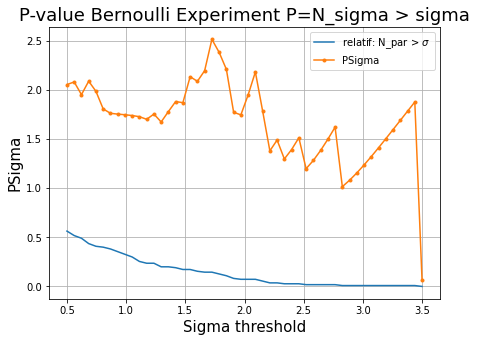

In [61]:
plotBernouliPValue(Matrix, True)

In [63]:
def plotBernoulliPSigmaSave(setMatrixes, labels = None, parameters = "All", figsize=(7,5),SaveLocation = "", title=""):
    if (not type(setMatrixes)==list) and len(setMatrixes.shape)==2: # Aka just a normal matrix
        # Create then a set of matrix with the number equal to 1
        setMatrixes = setMatrixes.reshape(-1,setMatrixes.shape[0],setMatrixes.shape[1])
    
    plotLabel = True
    if labels is None:# Create then some dummy array
        plotLabel = False
        labels = np.full(len(setMatrixes),"Dummy")
        
    fig = plt.figure(figsize=figsize, constrained_layout=False) # Needs to be false for the other plots
    
    for i, Matrix in enumerate(setMatrixes):
        sigma, PSigma = bernouliPValue(Matrix, parameters)
        plt.plot(sigma, PSigma, label = labels[i])

    plt.title(title,fontsize=18)
    plt.xlabel(r"P-value treshold of $H_{0,A=B}$ ($\sigma$)",fontsize=15)
    plt.ylabel(r"P-value binomial distr. ($\sigma$)",fontsize=15)
    if plotLabel:
        plt.legend(fontsize=14)
    plt.grid()
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.savefig(SaveLocation)

Number bernoulli Exp: 110


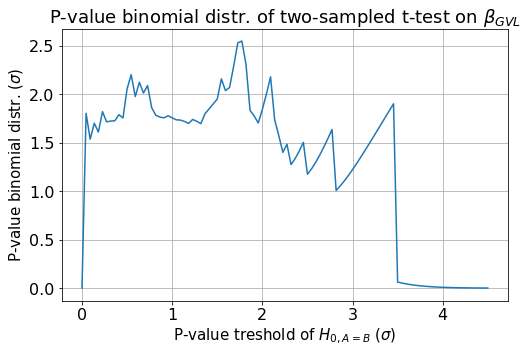

In [64]:
savePath = "ThesisFigures/ExperimentFig/PBinomial_Example.png"
title = r"P-value binomial distr. of two-sampled t-test on $\beta_{GVL}$" 
test = plotBernoulliPSigmaSave(Matrix, None,figsize=(8,5),SaveLocation=savePath, title=title)

Based on which sigma value you evaluate. You can have significance. If you define the significance on 2 sigma. 

However, I think it is important to focus on the on the the above of 2 sigma. Because it is for the higher sigma's that we need to watch out!

If you have significance for sigma 1. This means you observe more psameFitTest with a sigma of 1 then normally should be allowed if $H_0$ is true. -> Still this is actually also important. mmmh. I do not know where to draw the line...

Also it does not help that we are viewing here many matrix elements.. So you cannot specifically see this element is fitted badly. This is more a global assesment.

We can say the following:

- If $H_0$ is true is for all , then the average p_sigma value should be dabling around 0.67. And not the 1.75... 

But then again the 1.75 could have happend in a 1/20 chance.. And there is no way to again make again a second independed test since we need to use the same data... Hence we are stuck with this figure.

And we cannot globally reject it. But it comes close to for some sigma values. 

---
Interesting is though if the plot is significant up to a certain point say 2 sigma -> Then we can to say that for the interaction elements with higher then 2 sigma that among these some of the interaction elements are fitted not correctly! 


## Explore more same Fit results:

Let's first explore the f20 for all the regions Non MaxSTD, And just for the first 50 reference species.

In [52]:
#intersting seeds 39, 40 shows clearly under limit
# 21 for 20 nice shows very clearly the limit.

In [200]:
seed = [20]
listMatrix_f20_nonMaxStd = []
listLabels_f20_nonMaxStd = []
for zone in Zones:
    datasetName = "f20_"+zone
    listLabels_f20_nonMaxStd.append(datasetName)
    listMatrix_f20_nonMaxStd.append( sameFitTest_Matrix(datasetName, datasetName, zone, zone, seed, np.arange(100)))
listMatrix_f20_nonMaxStd = np.array(listMatrix_f20_nonMaxStd)

Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420


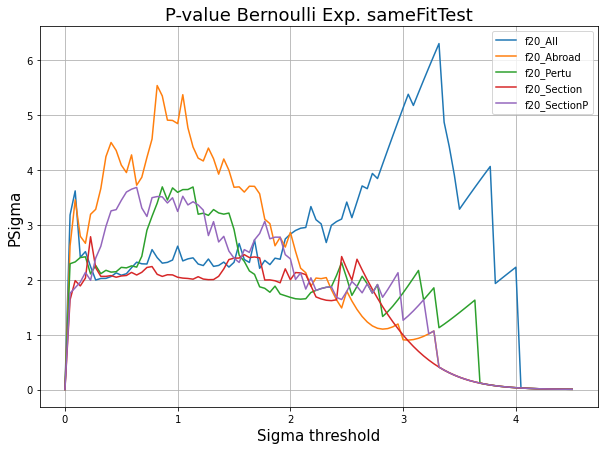

In [201]:
plotBernoulliPSigma(listMatrix_f20_nonMaxStd, listLabels_f20_nonMaxStd,figsize=(10,7))

In [202]:
#np.save("listMatrix_20_seed20",listMatrix_f20_nonMaxStd)

Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420


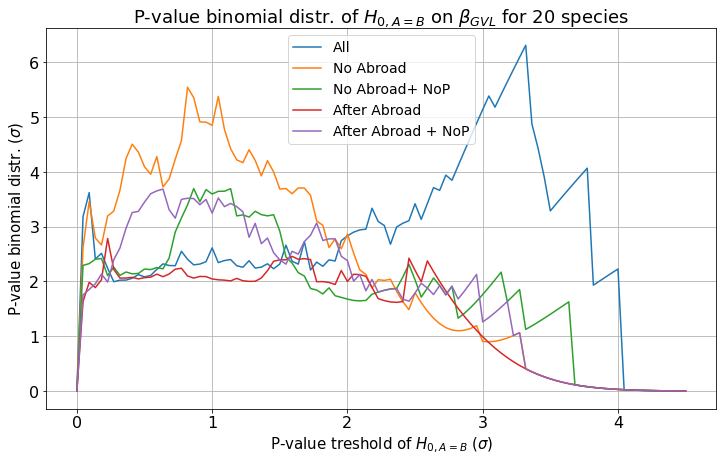

In [209]:
test20_Example = np.load("listMatrix_20_seed20.npy")
savePath = "ThesisFigures/ExperimentFig/f20Zones.png"
title = r"P-value binomial distr. of $H_{0,A=B}$ on $\beta_{GVL}$ for 20 species" 
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
plotBernoulliPSigmaSave(test20_Example, labels,figsize=(12,7),SaveLocation=savePath, title=title)

In [50]:
#np.save("listMatrix_50_seed24",listMatrix_f50_nonMaxStd)
type([0,0])==list

True

Number bernoulli Exp: 2550
Number bernoulli Exp: 2550
Number bernoulli Exp: 2550
Number bernoulli Exp: 2550
Number bernoulli Exp: 2550


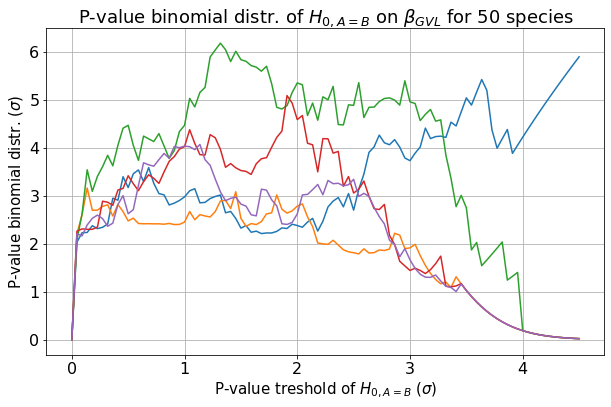

In [39]:
test50 = np.load("listMatrix_50_seed24.npy")
savePath = "ThesisFigures/ExperimentFig/f50Zones_NumberExample.png"
title = r"P-value binomial distr. of $H_{0,A=B}$ on $\beta_{GVL}$ for 50 species" 
plotBernoulliPSigmaSave(test50, None,figsize=(10,6),SaveLocation=savePath, title=title)

Number bernoulli Exp: 110
Number bernoulli Exp: 2550
Number bernoulli Exp: 2550


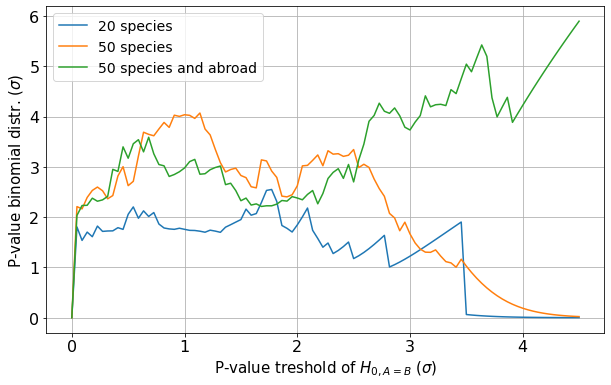

In [54]:
subset50 = np.load("listMatrix_50_seed24.npy")[[0,-1],:]
ListTest = [Matrix, subset50[1], subset50[0]]
savePath = "ThesisFigures/ExperimentFig/FigurePresentatie.png"
labels = ["20 species","50 species","50 species and abroad"]
plotBernoulliPSigmaSave(ListTest, labels,figsize=(10,6),SaveLocation=savePath, title="")

Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420


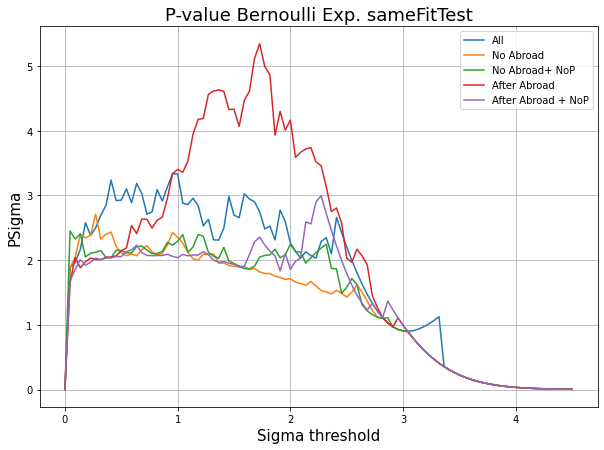

In [78]:
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
plotBernoulliPSigma(listMatrix_f20_nonMaxStd, labels, figsize=(10,7))

In [178]:
np.save("listMatrix_20_seed21",listMatrix_f20_nonMaxStd)

In [181]:
test20 = np.load("listMatrix_20_seed21.npy")

Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420
Number bernoulli Exp: 420


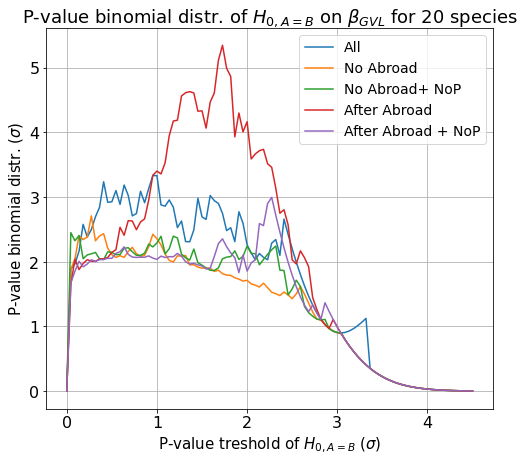

In [195]:
# Seed 21
test20 = np.load("listMatrix_20_seed21.npy")
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
savePath = "ThesisFigures/ExperimentFig/f20Zones_NumberExample.png"
title = r"P-value binomial distr. of $H_{0,A=B}$ on $\beta_{GVL}$ for 20 species" 
plotBernoulliPSigmaSave(test20, labels,figsize=(8,7),SaveLocation=savePath, title=title)

In [192]:
#np.save("listMatrix_10_seed10",listMatrix_f10_nonMaxStd)

Number bernoulli Exp: 110
Number bernoulli Exp: 110
Number bernoulli Exp: 110
Number bernoulli Exp: 110
Number bernoulli Exp: 110


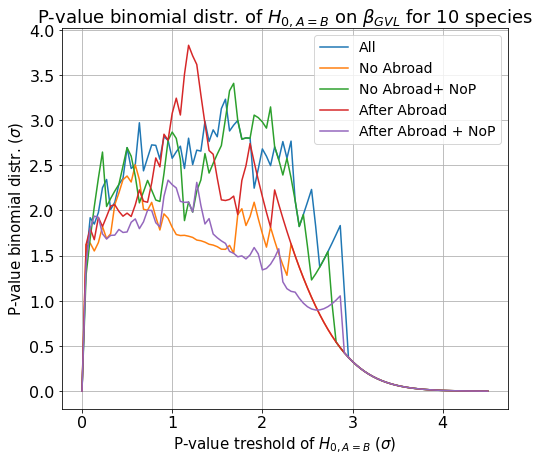

In [194]:
test10 = np.load("listMatrix_10_seed10.npy")
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
savePath = "ThesisFigures/ExperimentFig/f10Zones_NumberExample.png"
title = r"P-value binomial distr. of $H_{0,A=B}$ on $\beta_{GVL}$ for 10 species" 
plotBernoulliPSigmaSave(test10, labels,figsize=(8,7),SaveLocation=savePath, title=title)

### Discussion results:

What do we see? 

First, we see that for all the data it goes above the threshold of 2 sigma. Some even above the 3 Sigma for some cases. 

-> This means where it is above those PSigma values, There are just to much sigma values if the null hypothesis were to be true for all the species.

The peak of significance meaning the point sigma values that contains the largest excess, lies somewhere between 0.5->2. 

Meaning if we would view the matrix, we would see that most of the sigma values are contained nicely under the 2 sigma. Meaning for that interaction coeffiecient we could not say significantly they were different. However by now viewing this plot we do see that there are to many of these low moderate sigma cases. Which is significantly not correct! 

From this we can conclude that the null hypothesis is globally not correct. Sadly because we cannot say anything signficant on the individual level, we cannot pinpoint which data points where significantly fitted with a different value in mind. 

Importantly, we see that for all the datasets the curve goes to a normal level for higher sigma (not extreme high). Meaning we do not see an abnormal amount of higher sigma's for the statical test that the inferred values might not come from a different true value.

However, because of what we discussed before, we do have the feeling that $H_0$ is not being respected in some cases, -> Meaning the reason why see less of those high sigma is simply because of that the fitted sample varBEst is too broad in order to significantly detect the $H_0$ violation. And the reason it is to is because we simply have not enough points. 

At the end we see the effect that the curve becomes smooth. -> This is simply because there are not that much high sigma points.

However, for some datasets it seems that there are some points with a to high sigma amount, for the amount of values. -> These then also go above the 2 or even 3 sigma!

**Talk about difference between the datasets? Interpret them**

### What do we learn from this?

We have shown that $H_0$ is not valid for datasets when compared against itself. Meaning that the data does not follow the GLV model. And that fitted value with its given variance of estimation does not fit correctly to true value. However, because the test statiek never goes to large values (>3sigma), It does seems that the true value might not be that far away else we would have seen large significant fits. 

## Effect per type of interaction:

We want to see the effect for the different parts of the matrix since many of the interaction elements are non significant and maybe indeed in reality they are zero. 

We know in fact that growthrate and self interaction for some of the datasets fit significantly! And so it would be interesting to see how the same fit test would perform over there. 

### Growth rate:

### Self Interaction:

### Interaction terms:

### If possible difference between significant and non-signifanct interaction terms:

To do this we need to have some formal definition of which interaction terms we viewed as significant. 
To do this choose a specific dataset and from that extract the interaction that are considered significant. 

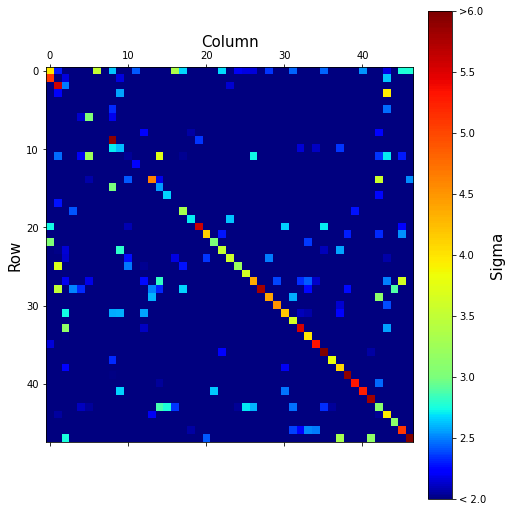

In [45]:
plotM( dFit["f50_SectionP_MaxStd"].pNullSigma[0], "", "Sigma", figsize=(7,7))

To talk about significance I do think it would be better to take the SectionP since it is the most clean one in types of here we know for sure that it is in steady state. Then I would also take the MaxStd one since in terms of significant it shows more. We should then be carefull to just select. 

-> Then select all the interaction terms with a certain sigma theshold. 2.5 sigma is already significant but it can pop up randomly. 

So actually put this matrix also through the bernoulli analysis and evaluate if the 2.5 sigma is significant or not!.

Number bernoulli Exp: 2162


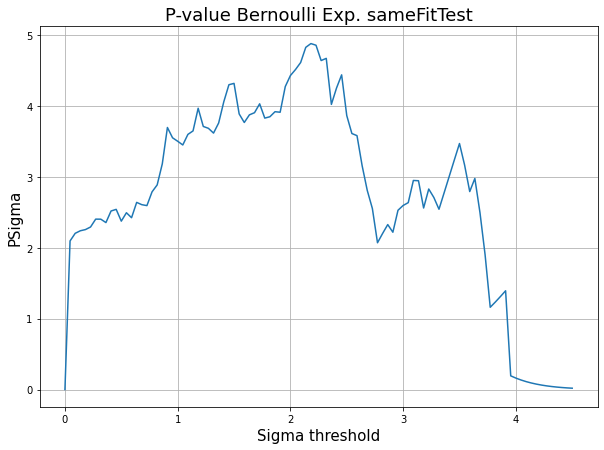

In [46]:
plotBernoulliPSigma( dFit["f50_SectionP_MaxStd"].pNullSigma, parameters="Interaction",figsize=(10,7))

:O This plot is actually very nice and actually we could have done this also with many earlier analysis. 

-> We see if we cut at 2.5 that we get mostly significant values -> And thus let's cut it there.

-> We could also cut at 3 sigma -> Which even stronger. 

In [47]:
dSignInter = {}
#dataset ="f50_SectionP_MaxStd"

for dataset, dictToSpecies in dDictSpecies.items():
    if dataset[:4] == "f100":
        continue
    for threshold in [2.5,3]:
        signInter = dFit[dataset].pNullSigma[0] > threshold
        signInter[0] = False # Set growth to false
        diagIndex = np.arange(signInter.shape[1])
        signInter[diagIndex+1, diagIndex] = False # Put the diagional terms equal to zero.
        
        # Now convert extract the location in terms of reference species.
        row, col = np.where(signInter)
        row -= 1 # Because of the growth
        if row.size==0:
            dSignInter[str(threshold)+"_"+dataset] = ([], [])
        else:
            reverseDict = dict((v,k) for k,v in dictToSpecies.items())
            row_ref = np.vectorize(reverseDict.get)(row)
            col_ref = np.vectorize(reverseDict.get)(col)
    
            dSignInter[str(threshold)+"_"+dataset] = (row_ref, col_ref)

use this dSingInter above. 

Number bernoulli Exp: 7
Number bernoulli Exp: 7
Number bernoulli Exp: 7
Number bernoulli Exp: 7
Number bernoulli Exp: 7


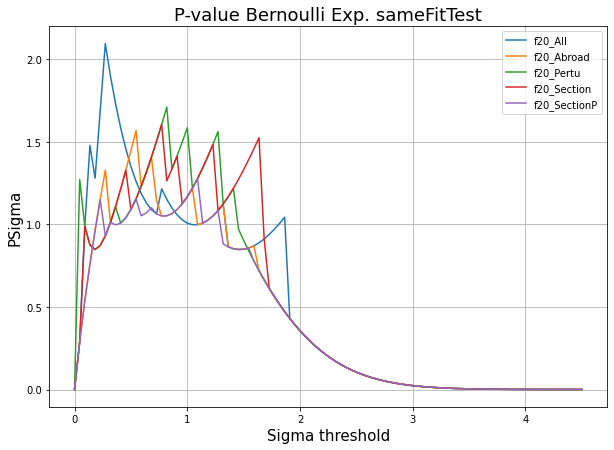

In [48]:
plotBernoulliPSigma(listMatrix_f20_nonMaxStd, listLabels_f20_nonMaxStd, "Sig_2.5_f20_SectionP", figsize=(10,7))

-> Problem not enough points such that the Bernoulli check does not really make sense-> Maybe more possible on the individual level.

But it seems that no point is above the 2 Sigma with the sameFitTest while, and knowing that we are talking interaction terms that were significant. -> This is actually strong because then it means because it means that the points that were fitted signifcantly are again significant when considering different subsets or (with even the different regions), Maybe the exaxt value would not be know, we could atleast tell which sign the interaction strenght is.

Because if this would have been the other or even zero well because before we fitted significant we expect that if the true is zero and or other sign that the sameFitTest would be significant. -> Which is highly not the case!

Also the number of p-value achieved with the bernoulli test are all in save regions (even though this should not be to much counted on since there are not that many points to begin with!. 

----

To be really certain look on the fits with the other regions: (This comparison only considers the same amount of species (f20) and NonDeletion **FURTHER INVESTIGATION IS MAYBE NEEDED:**). 

- Look at the if it still fits significant even if we have datasets with different amount of species
- Look at if they are different if we delete species!. 

Have a look at specificly the confident significant parameters.

In [49]:
SigRow, SigCol = dSignInter["2.5_f20_SectionP"]
print(SigRow)
print(SigCol)

[ 3  6 16 14 15 15 18]
[ 0 17 18  6  0  3  1]


Print there fitted value and P-value:

In [50]:
tempDictSigRowCol = {}
print("--------------------")
for zone in Zones:
    dataset = "f20_"+zone
    SigRow_zone = np.vectorize(dDictSpecies[dataset].get)(SigRow)+1
    SigCol_zone = np.vectorize(dDictSpecies[dataset].get)(SigCol)
    print("Zone = "+zone)
    print(f"Fitted Value = {np.round(dFit[dataset].BEst[0][(SigRow_zone,SigCol_zone)] , 2)}")
    print(f"P-value Fit = {np.round(dFit[dataset].pNullSigma[0][(SigRow_zone,SigCol_zone)] ,2)}")
    print("--------------------")

--------------------
Zone = All
Fitted Value = [-0.21 -0.2  -0.22  0.68 -0.07 -0.07 -0.06]
P-value Fit = [3.01 1.72 2.4  2.36 1.62 2.81 1.01]
--------------------
Zone = Abroad
Fitted Value = [-0.14 -0.28 -0.23  0.36 -0.05 -0.05 -0.09]
P-value Fit = [3.41 2.93 2.51 2.52 2.51 1.94 1.16]
--------------------
Zone = Pertu
Fitted Value = [-0.13 -0.3  -0.27  0.42 -0.06 -0.12 -0.14]
P-value Fit = [3.51 3.08 2.89 2.89 2.31 2.84 2.03]
--------------------
Zone = Section
Fitted Value = [-0.13 -0.26 -0.25  0.85 -0.07 -0.06 -0.14]
P-value Fit = [2.94 2.92 2.45 2.95 2.58 1.67 1.53]
--------------------
Zone = SectionP
Fitted Value = [-0.13 -0.31 -0.36  0.61 -0.09 -0.14 -0.22]
P-value Fit = [2.96 3.31 3.   3.23 2.55 2.65 2.57]
--------------------


## Explore difference between datasets:

Upuntil now, we have only consdired how we should interpret the result from just one the datasets. Like how trusted is the one dataset. 

However, we should also explore how large maybe the differences inbetween the different datasets since if the difference would be large then our results depend heavenly on what type of data set we chose.

### The effect of different number of species.

How much does our fitting get influenced by the different amount of species?

Let's consider this on one of the cleaner datasets: SectionP, which we firmly believe in that it has a cleaner steadystate.

Again consider the possible first 50 reference species. And compare the dataset difference between 10to10/ 10to20 and 10to50 (we do not consider 100 since SectionP is already very restrive by throwing away a lot) And to then divide by two an fit on 100 points -> Leaves not many degrees of freedom, fearing over fitting... 

Note, that we say considert the first 50 reference species but since we are comparing against 10, this probably means we do not get pas the first 15 refspecies.

In [51]:
seed = [19] 
listMatrix_SectionP_nonMaxStd = []
listLabels_SectionP_nonMaxStd = []
for N in [10, 20, 50]:
    dataset1 = "f10_SectionP"
    dataset2 = "f"+ str(N)+ "_SectionP"
    listLabels_SectionP_nonMaxStd.append("10vs"+str(N))
    
    listMatrix_SectionP_nonMaxStd.append( sameFitTest_Matrix(dataset1, dataset2, "SectionP", "SectionP", seed, np.arange(50)))

# Add also the 20vs50 case
listLabels_SectionP_nonMaxStd.append("20vs50")
listMatrix_SectionP_nonMaxStd.append( sameFitTest_Matrix("f20_SectionP", "f50_SectionP", "SectionP", "SectionP", seed, np.arange(50)))

listMatrix_SectionP_nonMaxStd = np.array(listMatrix_SectionP_nonMaxStd)

Number bernoulli Exp: 110
Number bernoulli Exp: 110
Number bernoulli Exp: 110
Number bernoulli Exp: 420


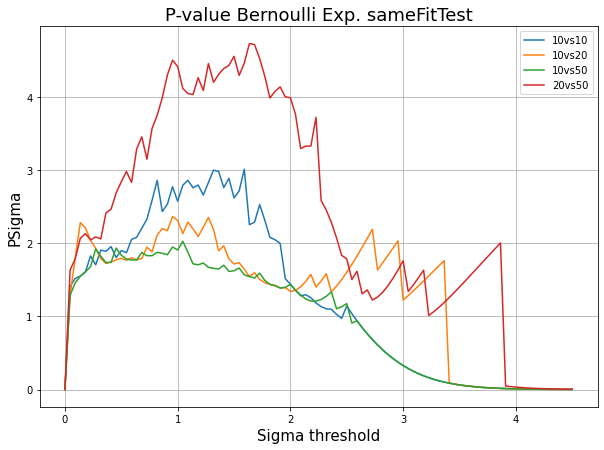

In [52]:
plotBernoulliPSigma(listMatrix_SectionP_nonMaxStd, listLabels_SectionP_nonMaxStd, figsize=(10,7))

#### Consideration of the between the different types interactions:

### The effects of different zones. 

For this consider a the 10 species and nonMax case:

And here compare the most clean region SectionP against all the other regions

In [196]:
#80
#77 Extremly interesting
seed = [82] 
listMatrix_f20_nonMaxStd = []
listLabels_f20_nonMaxStd = []
for zone in Zones:
    dataset1 = "f20_SectionP"
    dataset2 = "f20_"+zone
    listLabels_f20_nonMaxStd.append("SPvs"+zone)
    
    listMatrix_f20_nonMaxStd.append( sameFitTest_Matrix(dataset1, dataset2, "SectionP", zone, seed, np.arange(50)))

listMatrix_f20_nonMaxStd = np.array(listMatrix_f20_nonMaxStd)

Considerations for the significant few:

In [316]:
dDictSpecies["f10_Pertu"]

{0: 0, 1: 1, 2: 3, 3: 4, 4: 2, 5: 8, 6: 5, 7: 6, 8: 7, 10: 9}

Number bernoulli Exp: 342
Number bernoulli Exp: 380
Number bernoulli Exp: 380
Number bernoulli Exp: 380
Number bernoulli Exp: 420


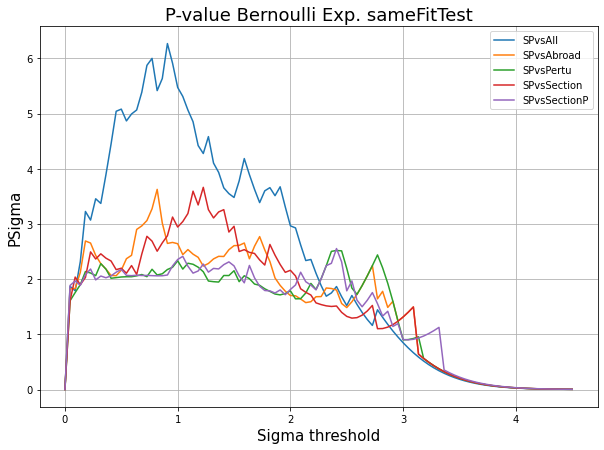

In [197]:
plotBernoulliPSigma(listMatrix_f20_nonMaxStd, listLabels_f20_nonMaxStd, figsize=(10,7))


In [198]:
#np.save("listMatrix_AgainstZones",listMatrix_f20_nonMaxStd)

Number bernoulli Exp: 342
Number bernoulli Exp: 380
Number bernoulli Exp: 380
Number bernoulli Exp: 380
Number bernoulli Exp: 420


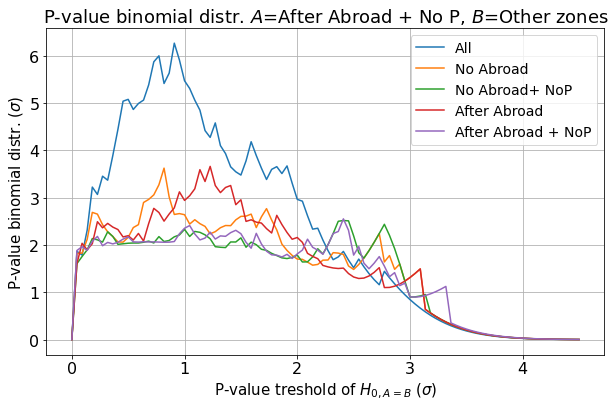

In [216]:
# Seed 82
ListMatrixAgainstZones = np.load("listMatrix_AgainstZones.npy")
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
savePath = "ThesisFigures/ExperimentFig/DifferentRegions.png"
title = r"P-value binomial distr. $A$=After Abroad + No P, $B$=Other zones" 
plotBernoulliPSigmaSave(ListMatrixAgainstZones, labels,figsize=(10,6),SaveLocation=savePath, title=title)

-> Surprsingly not actually! Except with "all" can we significantly say there are to much difference but with all the rest not! very nice result actually, which clearly shows that excluding the abroad section does have an influance. 

### The effect of StdMax or not? 

Does removing those very high StdMax have an influence? Have a look at the difference between the f10 for each section with the std

In [97]:
Zones

['All', 'Abroad', 'Pertu', 'Section', 'SectionP']

In [212]:
# 23
seed = [29] 
listMatrix_f20againstSTD = []
listLabels_f20againstSTD = []
for zone in Zones:
    dataset1 = "f20_"+zone
    dataset2 = "f20_"+zone+"_MaxStd"
    listLabels_f20againstSTD.append(zone)
    
    listMatrix_f20againstSTD.append( sameFitTest_Matrix(dataset1, dataset2, zone, zone, seed, np.arange(50)))

listMatrix_f20againstSTD = np.array(listMatrix_f20againstSTD)

In [56]:
plotBernoulliPSigma(listMatrix_f10againstSTD, listLabels_f10againstSTD, figsize=(10,7))

NameError: name 'listMatrix_f10againstSTD' is not defined

Number bernoulli Exp: 72
Number bernoulli Exp: 182
Number bernoulli Exp: 182
Number bernoulli Exp: 132
Number bernoulli Exp: 132


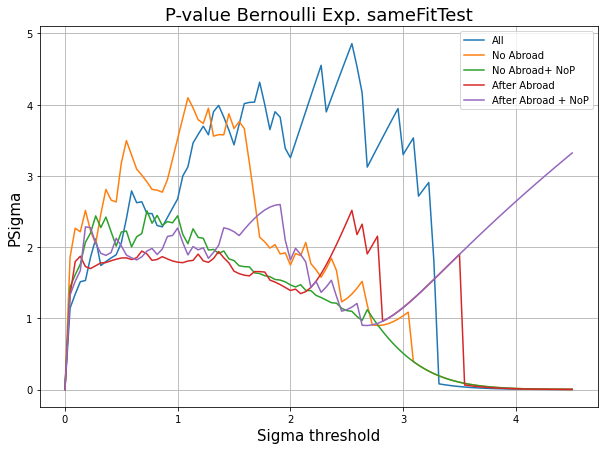

In [213]:
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
plotBernoulliPSigma(listMatrix_f20againstSTD, labels, figsize=(10,7))

In [214]:
np.save("listMatrix_RemovalHighVar",listMatrix_f20againstSTD)

Number bernoulli Exp: 72
Number bernoulli Exp: 182
Number bernoulli Exp: 182
Number bernoulli Exp: 132
Number bernoulli Exp: 132


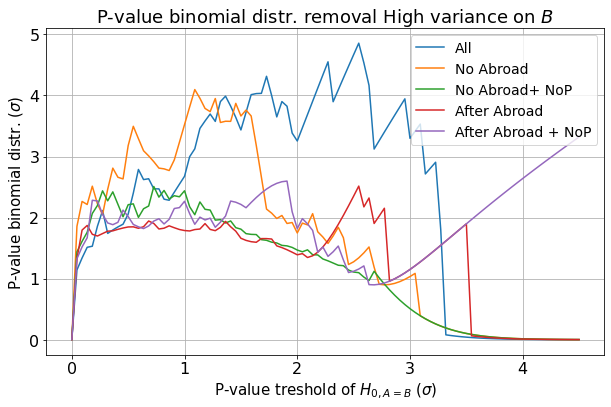

In [215]:
# Seed 82
ListMatrixRemovalHighStd = np.load("listMatrix_RemovalHighVar.npy")
labels = ["All","No Abroad","No Abroad+ NoP", "After Abroad", "After Abroad + NoP"] 
savePath = "ThesisFigures/ExperimentFig/removeMaxSTD.png"
title = r"P-value binomial distr. removal High variance on $B$" 
plotBernoulliPSigmaSave(ListMatrixRemovalHighStd, labels,figsize=(10,6),SaveLocation=savePath, title=title)

For f10

In general it has an influence on anything but not like more then it has on itself. 

-> However, it does seem to have a large effect influance on All and Abroad side. On the other it acutally does not influence that much. 

-> Lets have maybe a 

for f20

It seems to be even worse in the all case! Not so much for the other species -> 

So std Max seems does seem to have influence surely on the all case. But not apperently not on the other. Knowing how much variablilyt there actually is on the data set itself. ! That is actually important to note for differences! -> changing an aspect is actually only really relevant when it exceeds that of of the standard dataset. Which is here surely the case for the stdMax.

## General caviat:

Problem with this analyisis it can only say that it possible fits something differently but it does not say anything about fitting about which fit is good or not?

In general these plots are also difficult to interpret since comparing these graphs it is difficult to know if the change is now significant or not... 

# Plotting figures:

Number bernoulli Exp: 380


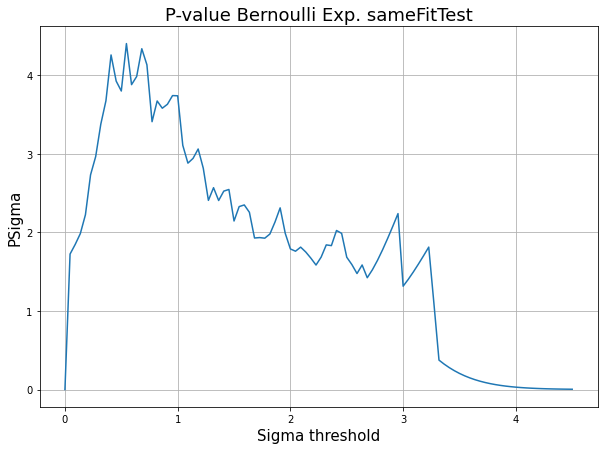

In [83]:
plotBernoulliPSigma( dFit["f20_SectionP"].pNullSigma, parameters="Interaction",figsize=(10,7))

## Fit figures thesis:

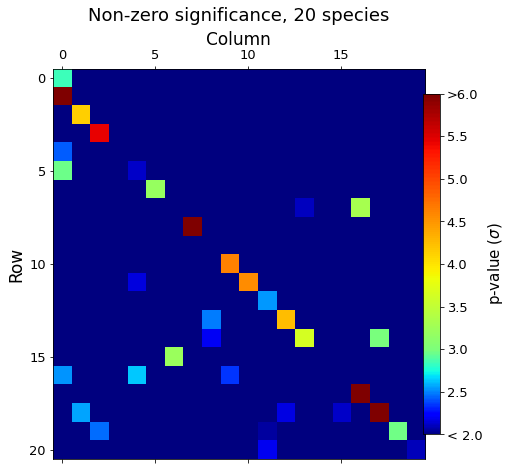

In [25]:
#plt.savefig('ThesisFigures/ExperimentFig/Fit_f20SectionP.png')
plotM( dFit["f20_SectionP"].pNullSigma[0], "Non-zero significance, 20 species", "Sigma", figsize=(7,7))
#plotM( dFit["f20_All"].BEst[0], "Parmeter fit first 20, after abroad without Pertu.", "PosNeg", figsize=(7,7))

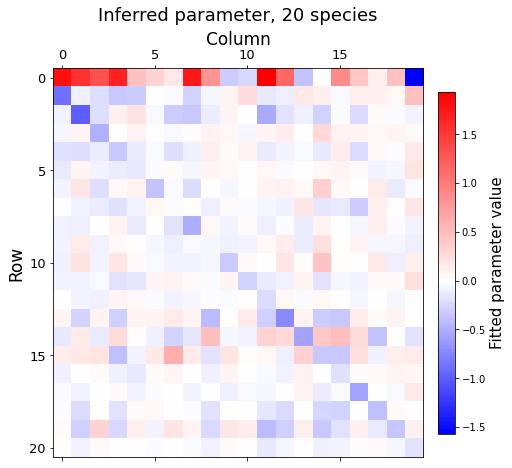

In [26]:
#plt.savefig('ThesisFigures/ExperimentFig/Fit_f20SectionP_Infer.png')
plotM( dFit["f20_SectionP"].BEst[0], "Inferred parameter, 20 species", "PosNeg", figsize=(7,7))

Number bernoulli Exp: 380


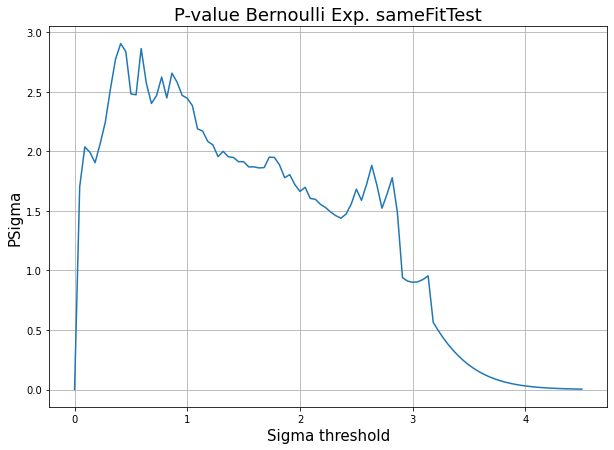

In [82]:
plotBernoulliPSigma( dFit["f20_SectionP_MaxStd"].pNullSigma, parameters="Interaction",figsize=(10,7))

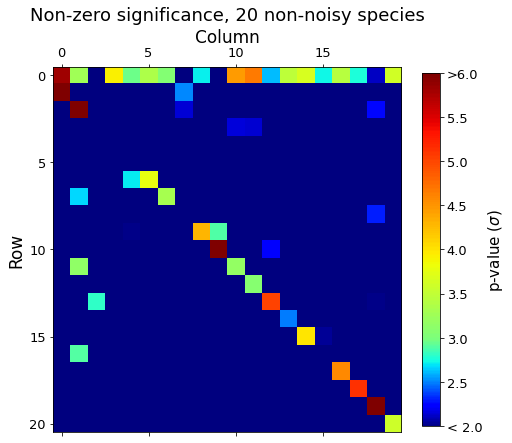

In [34]:
#plt.savefig('ThesisFigures/ExperimentFig/Fit_f20SectionP_MaxStd.png')
plotM( dFit["f20_SectionP_MaxStd"].pNullSigma[0], "Non-zero significance, 20 non-noisy species", "Sigma", figsize=(7,7))
#plotM( dFit["f50_All_MaxStd"].BEst[0], "Parmeter fit first 20, after abroad with Pertu.", "PosNeg", figsize=(7,7))

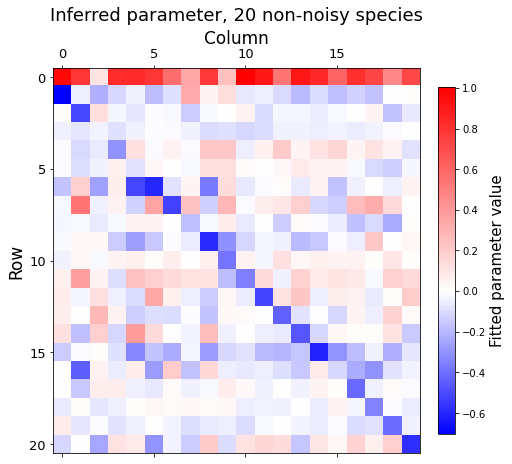

In [39]:
#plt.savefig('ThesisFigures/ExperimentFig/Fit_f20SectionP_MaxStd_Infer.png')
plotM( dFit["f20_SectionP_MaxStd"].BEst[0], "Inferred parameter, 20 non-noisy species", "PosNeg", figsize=(7,7))

-------------__

Fit results to compare back towards the original:

What is the noise strength and interaction strength of the system?

In [52]:
np.median(np.sqrt(dFit["f20_SectionP"].varEst[0]))

0.6922769896500596

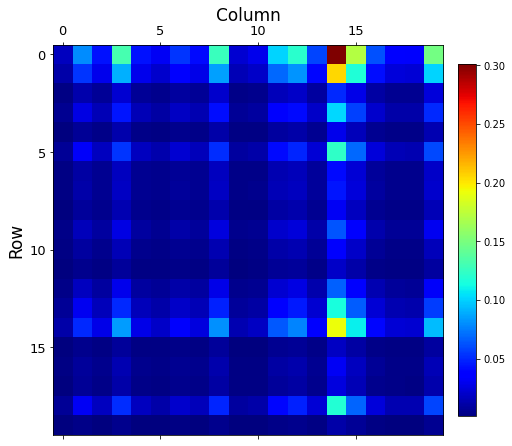

In [33]:
plotM(dFit["f20_SectionP"].varBEst[0][1:],"",figsize=(7,7))

Text(0.5, 1.0, 'Distribution variance interaction parameters')

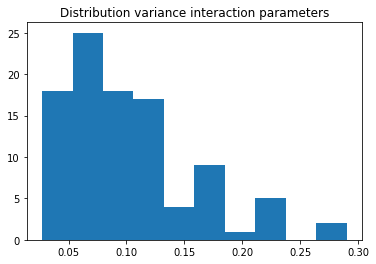

In [41]:
plt.hist(np.sqrt(dFit["f20_SectionP"].varBEst[0][10:,:9].flatten()))
plt.title("Distribution variance interaction parameters")

Text(0.5, 1.0, 'Distribution interaction parameters')

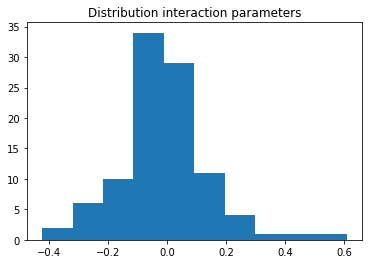

In [42]:
plt.hist(dFit["f20_SectionP"].BEst[0][10:,:9].flatten())
plt.title("Distribution interaction parameters")

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols= 2,figsize=(15,10),constrained_layout = True )




In [43]:
print("Magnitude of the inference")
np.std(dFit["f20_SectionP"].BEst[0][10:,:9])

0.15504600447323316

In [48]:
print("Median std value")
np.median(np.sqrt(dFit["f20_SectionP"].varBEst[0][10:,:9]) ) 

Median std value


0.09067535838722522

# Supplement figures.

I want to create, comparison 10 and 50, for section P

And I want to create 20 for abroad
and 20 for All:
-> 8 Figures:

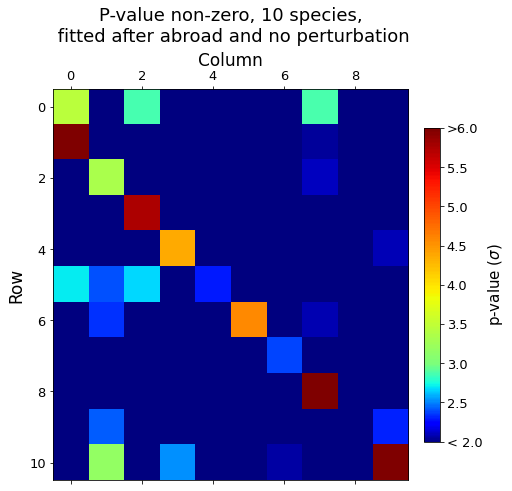

In [68]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f10SectionP.png')
plotMSave( dFit["f10_SectionP"].pNullSigma[0], "P-value non-zero, 10 species,\n fitted after abroad and no perturbation", "Sigma", figsize=(7,7),pathToSave=SavePath)

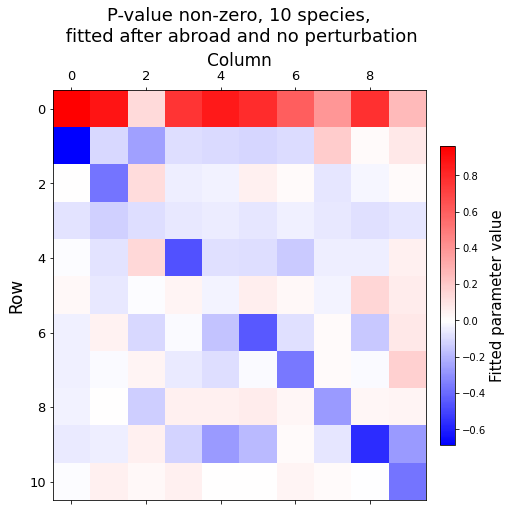

In [71]:
SavePath = ('ThesisFigures/ExperimentFig/test2.png')
plotMSave( dFit["f10_SectionP_MaxStd"].BEst[0], "P-value non-zero, 10 species,\n fitted after abroad and no perturbation", "PosNeg", figsize=(7,7),pathToSave=SavePath)

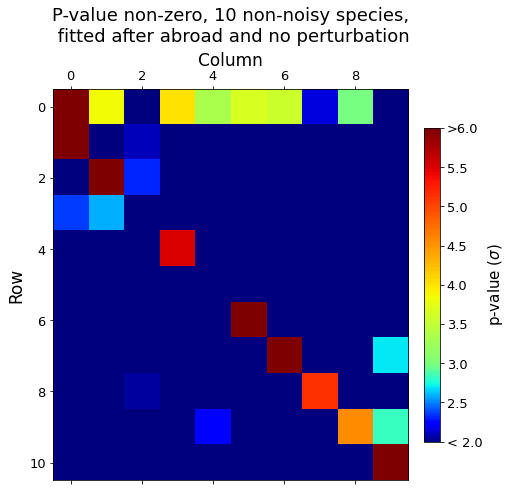

In [42]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f10SectionP_MaxStd.png')
plotMSave( dFit["f10_SectionP_MaxStd"].pNullSigma[0], "P-value non-zero, 10 non-noisy species,\n fitted after abroad and no perturbation", "Sigma", figsize=(7,7),pathToSave=SavePath)

------

For 50 one needs to recompute the Std thesholds with f100 instead of f50

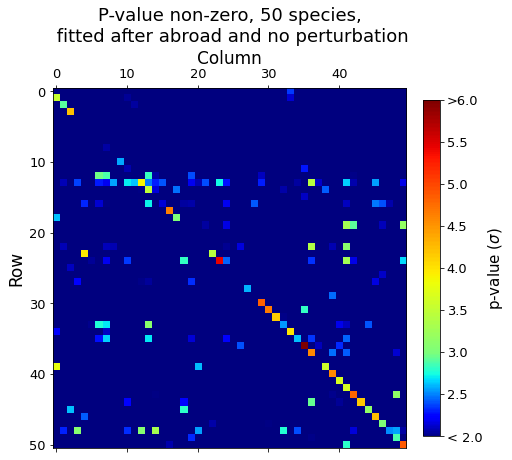

In [48]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f50SectionP.png')
plotMSave( dFit["f50_SectionP"].pNullSigma[0], "P-value non-zero, 50 species,\n fitted after abroad and no perturbation", "Sigma", figsize=(7,7),pathToSave=SavePath)

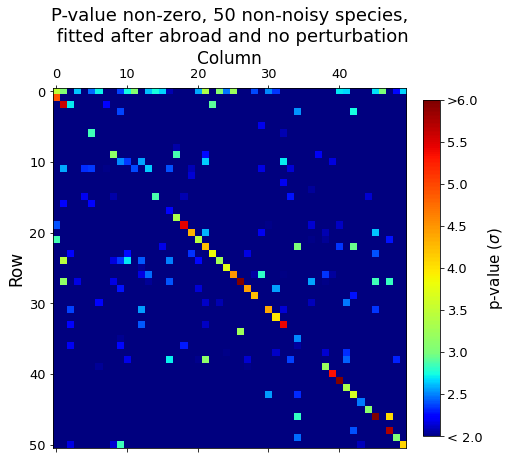

In [74]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f50SectionP_MaxStd.png')
plotMSave( dFit["f50_SectionP_MaxStd"].pNullSigma[0], "P-value non-zero, 50 non-noisy species,\n fitted after abroad and no perturbation", "Sigma", figsize=(7,7),pathToSave=SavePath)

---------------

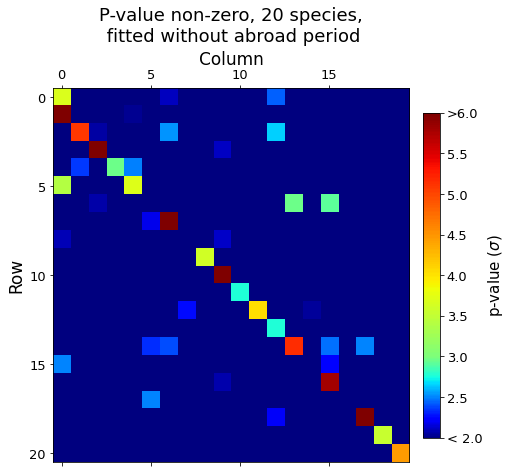

In [39]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f20Abroad.png')
plotMSave( dFit["f20_Abroad"].pNullSigma[0], "P-value non-zero, 20 species,\n fitted without abroad period", "Sigma", figsize=(7,7),pathToSave=SavePath)

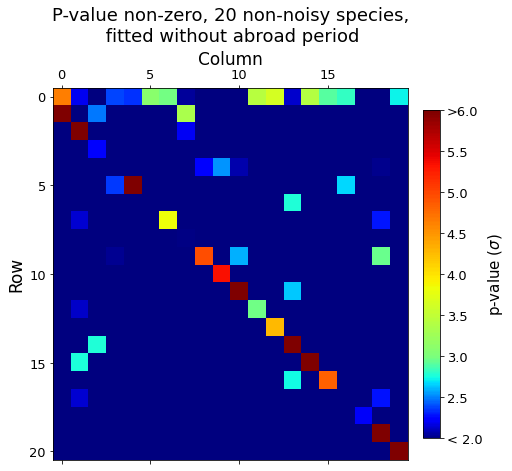

In [40]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f20Abroad_MaxStd.png')
plotMSave( dFit["f20_Abroad_MaxStd"].pNullSigma[0], "P-value non-zero, 20 non-noisy species,\n fitted without abroad period", "Sigma", figsize=(7,7),pathToSave=SavePath)

---

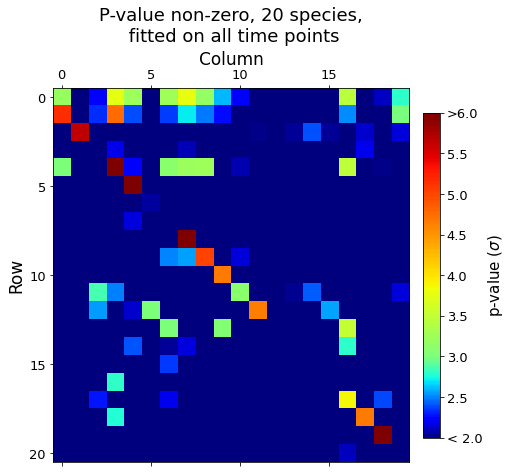

In [44]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f20All.png')
plotMSave( dFit["f20_All"].pNullSigma[0], "P-value non-zero, 20 species,\n fitted on all time points", "Sigma", figsize=(7,7),pathToSave=SavePath)

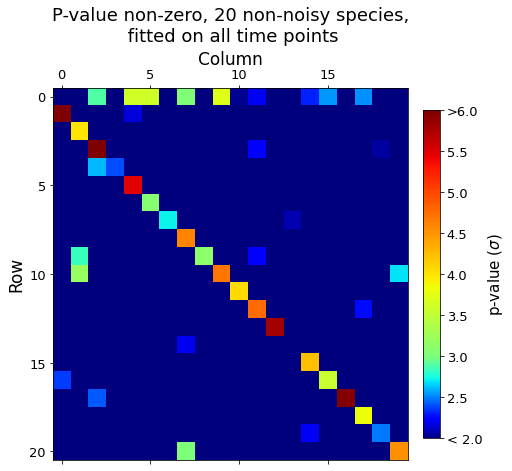

In [45]:
SavePath = ('ThesisFigures/ExperimentFig/Fit_f20All_MaxStd.png')
plotMSave( dFit["f20_All_MaxStd"].pNullSigma[0], "P-value non-zero, 20 non-noisy species,\n fitted on all time points", "Sigma", figsize=(7,7),pathToSave=SavePath)